# Imports

In [ ]:
# Imports
import torch
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Setting some hyperparameters

In [ ]:
# Hyperparameters
in_channels = 1                # change to 3 if you use CIFAR10 dataset
image_size = 28                # change to 32 if you use CIFAR10 dataset
num_classes = 10
lr = 4e-3
batch_size = 128
num_epochs = 5
channel_dim = 128
token_dim = 64
depth = 4
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the dataset

In [ ]:
# Load Data
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(in_channels)], [0.5 for _ in range(in_channels)]
                            ),
    ]
                                )

# MNIST Dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

# CIFAR10 Dataset
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 152437160.83it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 23892641.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 57976421.74it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20752209.99it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



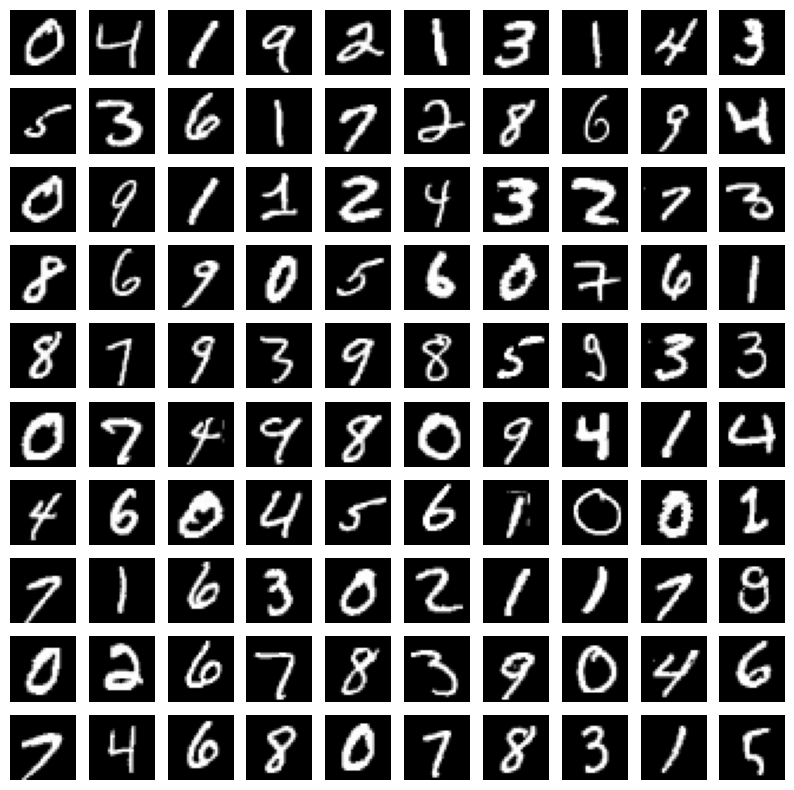

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(1, 101, 1):
  plt.subplot(10, 10, i)
  plt.imshow(trainset.data[i], cmap='gray')
  plt.axis('off')
plt.show()

# Defining MLP-Mixer Model
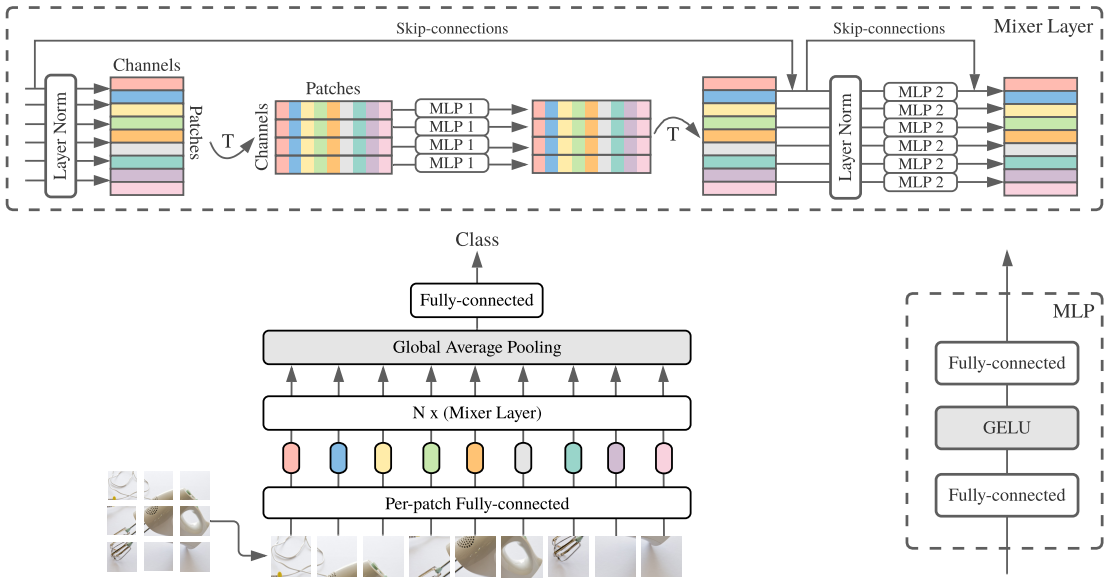


In [ ]:
class Patch_Embedding(nn.Module):
    """Patch Embedding layer is nothing but a convolutional layer
       with kernelsize and stride equal to patch size."""
    def __init__(self, in_channels, embedding_dim, patch_size):
        super().__init__()
        self.patch_embedding = nn.Conv2d(in_channels, embedding_dim, patch_size, patch_size)

    def forward(self, x):
        return self.patch_embedding(x)

class MLP(nn.Module):
    """This network applies 2 consecutive fully connected layers and is used
       in Token Mixer and Channel Mixer modules."""
    def __init__(self, dim, intermediate_dim, dropout = 0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim, intermediate_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(intermediate_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.mlp(x)

class T1(nn.Module):
    """The transformation that is used in Mixer Layer (the T)
       which just swithes the 2nd and the 3rd dimensions and is
       applied before and after Token Mixing MLPs"""
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.permute(x, (0, 2, 1))

class T2(nn.Module):
    """The transformation that is applied right after the patch embedding layer
       and convert it's shape from (batch_size, embedding_dim, sqrt(num_patches), sqrt(num_patches))
       to (batch_size, num_patches, embedding_dim)"""
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.permute(x, (0, 2, 3, 1)).reshape(x.shape[0], -1, x.shape[1])

class MixerLayer(nn.Module):
    """Mixer layer which consists of Token Mixer and Channel Mixer modules
       in addition to skip connections.
       intermediate_output = Token Mixer(input) + input
       final_output = Channel Mixer(intermediate_output) + intermediate_output"""
    def __init__(self, embedding_dim, num_patch, token_intermediate_dim, channel_intermediate_dim, dropout = 0.):
        super().__init__()

        self.token_mixer = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            T1(),
            MLP(num_patch, token_intermediate_dim, dropout),
            T1()
        )

        self.channel_mixer = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            MLP(embedding_dim, channel_intermediate_dim, dropout),
        )

    def forward(self, x):

        x = x + self.token_mixer(x)    # Token mixer and skip connection
        x = x + self.channel_mixer(x)  # channel mixer and skip connection

        return x

class MLPMixer(nn.Module):
    """MLP-Mixer Architecture:
       1-Applies 'Patch Embedding' at first.
       2-Applies 'Mixer Layer' N times in a row.
       3-Performs 'Global Average Pooling'
       4-The learnt features are then passed to the classifier"""
    def __init__(self, in_channels, embedding_dim, num_classes, patch_size, image_size, depth, token_intermediate_dim, channel_intermediate_dim):
        super().__init__()

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.num_patch =  (image_size// patch_size) ** 2
        self.pe = nn.Sequential(
            Patch_Embedding(in_channels, embedding_dim, patch_size),
            T2(),
        )

        self.mixers = nn.ModuleList([MixerLayer(embedding_dim, self.num_patch, token_intermediate_dim, channel_intermediate_dim) for _ in range(depth)])
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.classifier = nn.Sequential(nn.Linear(embedding_dim, num_classes))

    def forward(self, x):

        x = self.pe(x)              # Patch Embedding layer
        for mixer in self.mixers:   # Applying Mixer Layer N times
            x = mixer(x)
        x = self.layer_norm(x)
        x = x.mean(dim=1)           # Global Average Pooling

        return self.classifier(x)

In [ ]:
X = torch.rand(64, 1, 28, 28) # a batch of 64 samples with 1 channel 28*28 images

pe = Patch_Embedding(1, 128, 4) # patch embedding layer
t1 = T1()                       # switches dimension "2" and "3"
t2 = T2()                       # flat the last 2 dimensions and switch dimension "2" and "3"
ml = MixerLayer(128, 49, 256, 256)

print("Inpput shape:                   ", X.shape)
y1 = pe(X)
print("Patch Embedding output shape:   ", y1.shape)
y2 = t2(y1)
print("T2 transformation output shape: ", y2.shape)
y3 = t1(y2)
print("T1 transformation output shape: ", y3.shape)
y4 = t1(y3)
print("T1 transformation output shape: ", y4.shape)
y5 = ml(y4)
print("Mixer Layer output shape:       ", y5.shape)

Inpput shape:                    torch.Size([64, 1, 28, 28])
Patch Embedding output shape:    torch.Size([64, 128, 7, 7])
T2 transformation output shape:  torch.Size([64, 49, 128])
T1 transformation output shape:  torch.Size([64, 128, 49])
T1 transformation output shape:  torch.Size([64, 49, 128])
Mixer Layer output shape:        torch.Size([64, 49, 128])


# Instantiating model and defining loss function and optimizer

In [ ]:
model = MLPMixer(in_channels=in_channels, image_size=image_size, patch_size=2, num_classes=10,
                  embedding_dim=channel_dim, depth=depth, token_intermediate_dim=token_dim, channel_intermediate_dim=channel_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
print("Number of trainable parameters in Million is : ",
      sum(p.numel() for p in model.parameters() if p.requires_grad_)/1e6)

Number of trainable parameters in Million is :  0.237722


# Training loop

In [ ]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_index, (images, targets) in loop:
        images = images.to(device)
        targets = targets.to(device)
        logits = model(images)
        loss =  criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # progress bar information updating
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

# Defining a loop for getting the accuracy of model on train and test splits

In [ ]:
# Get accuracy on training & test to see how good our model is
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            _, predictions = logits.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

In [ ]:
print(f"Accuracy on training set: {get_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {get_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 98.48
Accuracy on test set: 97.57
